In [1]:
from fgbuster import harmonic_ilc_alm,CMB
import healpy as hp
import pysm3
import pysm3.units as u
import sys
import curvedsky as cs
import cmb
import os
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('../')
from utils import camb_clfile,cli
import mpi
import matplotlib.pyplot as plt
import pickle as pl
from database import surveys,noise

In [2]:
infolder = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/'
dnside = 512
lmax = 3*dnside -1
maskpath = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits'
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]
mydir = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/HILC_debug'
os.makedirs(mydir,exist_ok=True)

In [3]:
mask = hp.ud_grade(hp.read_map(maskpath),dnside)

In [4]:
class INST:
    def __init__(self,beam,frequency):
        self.Beam = beam
        self.fwhm = beam
        self.frequency = frequency
        
def get_cmb():
    idx = 0
    fname = os.path.join(infolder,f"cmb_sims_{idx:04d}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_fg(v,fg_str):
    fname = os.path.join(fg_dir,f"{fg_str}_{int(v)}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def cmb_fg(v,fg_model):
    fname = os.path.join(mydir,f'total_{int(v)}_{fg_model}.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        maps = get_cmb() + get_fg(v,fg_model)
        hp.write_map(fname,maps)
        return maps

def get_noise_map(v,depth_i,depth_p):
    depth_i = np.array([depth_i])
    depth_p = np.array([depth_p])
    fname = os.path.join(mydir,f'noise_{int(v)}_formodel.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        pix_amin2 = 4. * np.pi / float(hp.nside2npix(dnside)) * (180. * 60. / np.pi) ** 2
        """sigma_pix_I/P is std of noise per pixel. It is an array of length
        equal to the number of input maps."""
        sigma_pix_I = np.sqrt(depth_i ** 2 / pix_amin2)
        sigma_pix_P = np.sqrt(depth_p ** 2 / pix_amin2)
        npix = hp.nside2npix(dnside)
        noise = np.random.randn(len(depth_i), 3, npix)
        noise[:, 0, :] *= sigma_pix_I[:, None]
        noise[:, 1, :] *= sigma_pix_P[:, None]
        noise[:, 2, :] *= sigma_pix_P[:, None]
        noise = noise[0]
        hp.write_map(fname,noise)
        return noise

def get_exp_maps(v,depth_i,depth_p,beam,fg_model):
    fl = hp.gauss_beam(np.radians(beam/60),lmax=lmax, pol=True).T
    maps = hp.smoothing(cmb_fg(v,fg_model),fwhm=np.radians(beam/60)) + get_noise_map(v,depth_i,depth_p)
    alms = hp.map2alm(maps)
    hp.almxfl(alms[0],cli(fl[0]),inplace=True)
    hp.almxfl(alms[1],cli(fl[1]),inplace=True)
    hp.almxfl(alms[2],cli(fl[2]),inplace=True)
    return alms

def get_exp_arr(v,n_t,n_p,beam,fg_model):
        arr = []
        for i in tqdm(range(len(v)),desc="Making map",unit='Freq'):
            arr.append(get_exp_maps(v[i],n_t[i],n_p[i],beam[i],fg_model))
        return np.array(arr)

def apply_harmonic_W(W,  # (..., ell, comp, freq)
                      alms):  # (freq, ..., lm)
    lmax = hp.Alm.getlmax(alms.shape[-1])
    res = np.full((W.shape[-2],) + alms.shape[1:], np.nan, dtype=alms.dtype)
    start = 0
    for i in range(0, lmax+1):
        n_m = lmax + 1 - i
        res[..., start:start+n_m] = np.einsum('...lcf,f...l->c...l',
                                              W[..., i:, :, :],
                                              alms[..., start:start+n_m])
        start += n_m
    return res

In [16]:
fg_dir = '/global/cscratch1/sd/lonappan/S4BIRD/FG'
fg_str1 = "s0d0"
fg_str2 = "s1d1"

Tcmb  = 2.726e6

table = surveys().get_table_dataframe("LITEBIRD_V1")
table = table[table.frequency > 0]
exp_freqs = np.array(table.frequency)
exp_beam = np.array(table.fwhm)
exp_nlev_p = np.array(table.depth_p)
exp_nlev_t = exp_nlev_p/np.sqrt(2)

In [12]:
instrument = INST(None,exp_freqs)
components = [CMB()]
bins = np.arange(1000) * 10

In [9]:
alms1= get_exp_arr(exp_freqs,exp_nlev_t,exp_nlev_p,exp_beam,fg_str1)

Making map:   0%|          | 0/15 [00:00<?, ?Freq/s]setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
Making map:   7%|▋         | 1/15 [01:14<17:27, 74.81s/Freq]setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
Making map:  13%|█▎        | 2/15 [02:27<15:54, 73.43s/Freq]setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
Making map:  20%|██        | 3/15 [03:37<14:24, 72.00s/Freq]setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
Making map:  27%|██▋       | 4/15 [04:47<13:02, 71.14s/Freq]setting the 

In [10]:
alms2= get_exp_arr(exp_freqs,exp_nlev_t,exp_nlev_p,exp_beam,fg_str2)

Making map: 100%|██████████| 15/15 [20:01<00:00, 80.12s/Freq]


In [13]:
result1 = harmonic_ilc_alm(components, instrument,alms1,bins)

In [14]:
result2 = harmonic_ilc_alm(components, instrument,alms2,bins)

In [15]:
TEB1 = [result1.s[0,0],result1.s[0,1],result1.s[0,2]]
TEB2 = [result2.s[0,0],result2.s[0,1],result2.s[0,2]]

Text(0.5, 1.0, 's0d0')

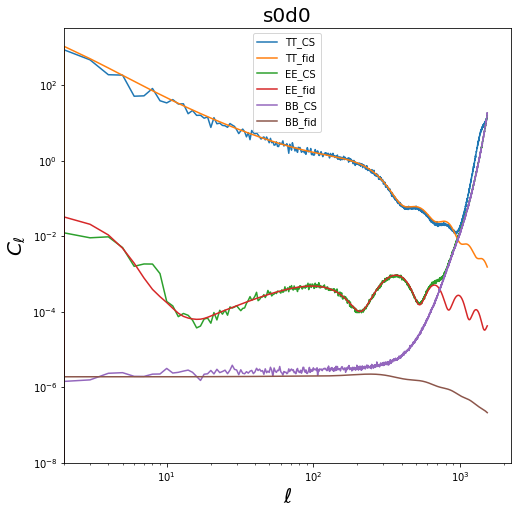

In [36]:

plt.figure(figsize=(8,8))
plt.loglog(hp.alm2cl(TEB1[0]),label='TT_CS')
plt.loglog(cl_len[0,:]*Tcmb**2,label='TT_fid')
plt.loglog(hp.alm2cl(TEB1[1]),label='EE_CS')
plt.loglog(cl_len[1,:]*Tcmb**2,label='EE_fid')
plt.loglog(hp.alm2cl(TEB1[2]),label='BB_CS')
plt.loglog(cl_len[2,:]*Tcmb**2,label='BB_fid')
plt.ylim(10**-8,None)
plt.xlim(2,None)
plt.legend()
plt.xlabel('$\ell$',fontsize=20)
plt.ylabel('$C_\ell$',fontsize=20)
plt.title('s0d0',fontsize=20)

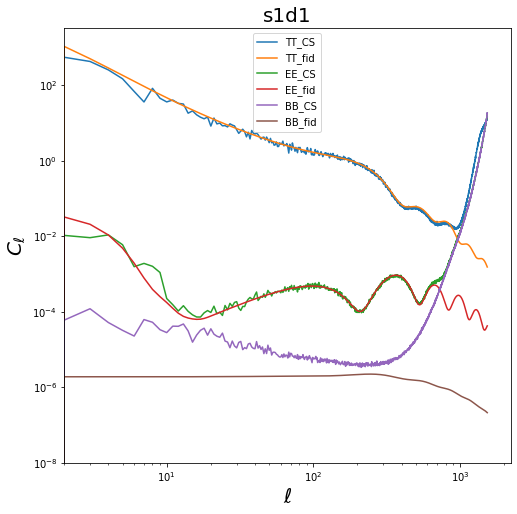

In [37]:


plt.figure(figsize=(8,8))
plt.loglog(hp.alm2cl(TEB2[0]),label='TT_CS')
plt.loglog(cl_len[0,:]*Tcmb**2,label='TT_fid')
plt.loglog(hp.alm2cl(TEB2[1]),label='EE_CS')
plt.loglog(cl_len[1,:]*Tcmb**2,label='EE_fid')
plt.loglog(hp.alm2cl(TEB2[2]),label='BB_CS')
plt.loglog(cl_len[2,:]*Tcmb**2,label='BB_fid')
plt.ylim(10**-8,None)
plt.xlim(2,None)
plt.xlabel('$\ell$',fontsize=20)
plt.ylabel('$C_\ell$',fontsize=20)
plt.title('s1d1',fontsize=20)
plt.legend()

In [20]:
noise_alm_arr = []
for v,n_t,n_p in zip(exp_freqs,exp_nlev_t,exp_nlev_p):
    noise_alm_arr.append(hp.map2alm(get_noise_map(v,n_t,n_p)))

In [21]:
w1 = result1.W
w2 = result2.W

In [22]:
nlm1 = apply_harmonic_W(w1,np.array(noise_alm_arr))[0]
nlm2 = apply_harmonic_W(w2,np.array(noise_alm_arr))[0]

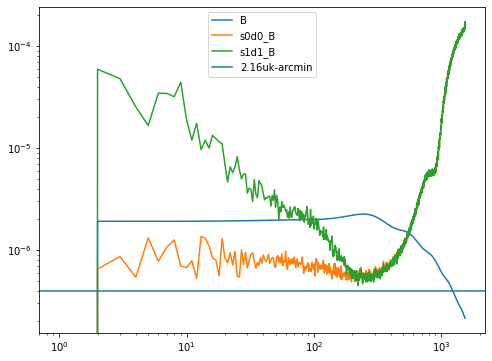

In [24]:
plt.figure(figsize=(8,6))
#plt.loglog(cl_len[0,:]*Tcmb**2,label='T')
#plt.loglog(cl_len[1,:]*Tcmb**2,label='E')
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
#plt.loglog(hp.alm2cl(nlm1[0]),label='s0d0_T')
#plt.loglog(hp.alm2cl(nlm1[1]),label='s0d0_E')
plt.loglog(hp.alm2cl(nlm1[2]),label='s0d0_B')
#plt.loglog(hp.alm2cl(nlm2[0]),label='s1d1_T')
#plt.loglog(hp.alm2cl(nlm2[1]),label='s1d1_E')
plt.loglog(hp.alm2cl(nlm2[2]),label='s1d1_B')
plt.axhline(np.radians(2.16/60)**2,label='2.16uk-arcmin')
plt.legend()

In [25]:
Nl_P = []
B_P = []
for b,n in zip(exp_beam,np.radians(exp_nlev_p/60)**2):
    B_P.append(hp.gauss_beam(np.radians(b/60),lmax=lmax))
    Nl_P.append(np.ones(lmax+1)*n)
Nl_P = np.array(Nl_P)
B_P = np.array(B_P)

In [41]:
w_ee1 = result1.W[1]
nl_ee1 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_ee1[i] = np.dot(Nl_P[:, i], w_ee1[i][0]**2)

w_ee2 = result2.W[1]
nl_ee2 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_ee2[i] = np.dot(Nl_P[:, i], w_ee2[i][0]**2)

In [26]:
w_bb1 = result1.W[2]
nl_bb1 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_bb1[i] = np.dot(Nl_P[:, i], w_bb1[i][0]**2)

w_bb2 = result2.W[2]
nl_bb2 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_bb2[i] = np.dot(Nl_P[:, i], w_bb2[i][0]**2)

Text(0, 0.5, '$N_\\ell$')

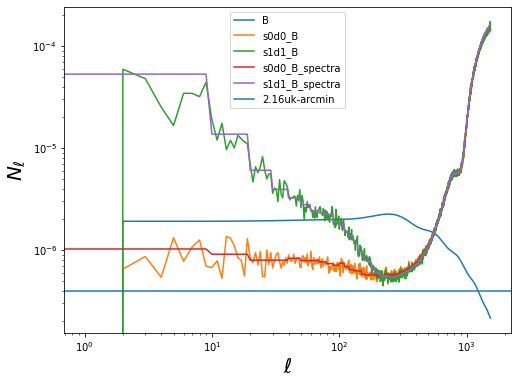

In [29]:
from tkinter import font


plt.figure(figsize=(8,6))
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
plt.loglog(hp.alm2cl(nlm1[2]),label='s0d0_B')
plt.loglog(hp.alm2cl(nlm2[2]),label='s1d1_B')
plt.loglog(nl_bb1,label='s0d0_B_spectra')
plt.loglog(nl_bb2,label='s1d1_B_spectra')
plt.axhline(np.radians(2.16/60)**2,label='2.16uk-arcmin')
plt.legend()
plt.xlabel('$\ell$',fontsize=20)
plt.ylabel('$N_\ell$',fontsize=20)

In [45]:
bl = hp.gauss_beam(np.radians(30/60),lmax=lmax)
Bl = np.reshape(bl,(1,lmax+1))

In [46]:
TQU1 = hp.smoothing(hp.alm2map(TEB1,dnside),fwhm=np.radians(30/60))

In [47]:
TQU2 = hp.smoothing(hp.alm2map(TEB2,dnside),fwhm=np.radians(30/60))

In [48]:
QU1 = np.reshape(np.array((TQU1[1]*mask,TQU1[2]*mask)),(2,1,hp.nside2npix(dnside)))/Tcmb
QU2 = np.reshape(np.array((TQU2[1]*mask,TQU2[2]*mask)),(2,1,hp.nside2npix(dnside)))/Tcmb

In [49]:
NL1 = np.reshape(np.array((cli(nl_ee1[:lmax+1]/Tcmb**2),cli(nl_bb1[:lmax+1]/Tcmb**2))),(2,1,lmax+1))
NL2 = np.reshape(np.array((cli(nl_ee2[:lmax+1]/Tcmb**2),cli(nl_bb2[:lmax+1]/Tcmb**2))),(2,1,lmax+1))

In [55]:
E1, B1 = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,
                                np.reshape(np.array((mask,mask)),(2,1,hp.nside2npix(dnside))),
                                QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt',inl=NL1,filter='W')

In [56]:
E2, B2 = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,
                                np.reshape(np.array((mask,mask)),(2,1,hp.nside2npix(dnside))),
                                QU2,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt',inl=NL2,filter='W')

/tmp/ipykernel_29707/3078842761.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


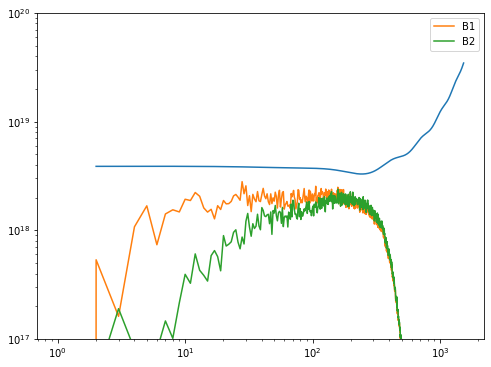

In [54]:
plt.figure(figsize=(8,6))
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B1),label='B1')
plt.loglog(cs.utils.alm2cl(lmax,B2),label='B2')
plt.ylim(1e17,1e20)
plt.legend()

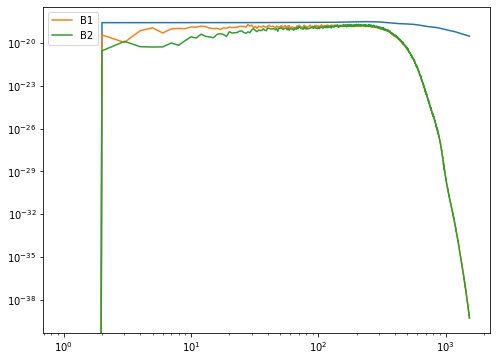

In [61]:
plt.figure(figsize=(8,6))
plt.loglog(cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B1),label='B1')
plt.loglog(cs.utils.alm2cl(lmax,B2),label='B2')
plt.legend()

In [98]:
TQU_CMB = get_cmb()
QU_CMB = np.reshape(np.array((TQU_CMB[1],TQU_CMB[2])),(2,1,hp.nside2npix(dnside)))/Tcmb
EB_CMB = cs.utils.hp_map2alm_spin(dnside,lmax,lmax,2,QU_CMB[0],QU_CMB[1])

/tmp/ipykernel_29707/312047413.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((cs.utils.alm2cl(lmax,EB_CMB[0],E1)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[0])*cs.utils.alm2cl(lmax,E1)))**2,label='s0d0_E')
/tmp/ipykernel_29707/312047413.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((cs.utils.alm2cl(lmax,EB_CMB[0],E2)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[0])*cs.utils.alm2cl(lmax,E2)))**2,label='s1d1_E')


Text(0, 0.5, 'E-Mode $\\rho^2_\\ell$')

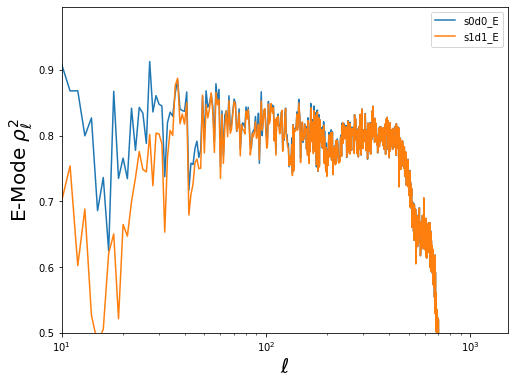

In [99]:
plt.figure(figsize=(8,6))
plt.plot((cs.utils.alm2cl(lmax,EB_CMB[0],E1)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[0])*cs.utils.alm2cl(lmax,E1)))**2,label='s0d0_E')
plt.plot((cs.utils.alm2cl(lmax,EB_CMB[0],E2)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[0])*cs.utils.alm2cl(lmax,E2)))**2,label='s1d1_E')
plt.semilogx()
plt.ylim(0.5,None)
plt.xlim(10,lmax)
plt.legend()
plt.xlabel('$\ell$',fontsize=20)
plt.ylabel("E-Mode $\\rho^2_\ell$",fontsize=20)

/tmp/ipykernel_29707/472740756.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((cs.utils.alm2cl(lmax,EB_CMB[1],B1)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[1])*cs.utils.alm2cl(lmax,B1)))**2,label='s0d0_B')
/tmp/ipykernel_29707/472740756.py:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((cs.utils.alm2cl(lmax,EB_CMB[1],B2)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[1])*cs.utils.alm2cl(lmax,B2)))**2,label='s1d1_B')


Text(0, 0.5, 'B-Mode $\\rho^2_\\ell$')

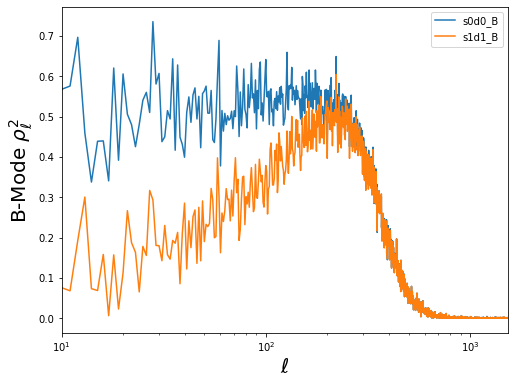

In [100]:
plt.figure(figsize=(8,6))
plt.plot((cs.utils.alm2cl(lmax,EB_CMB[1],B1)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[1])*cs.utils.alm2cl(lmax,B1)))**2,label='s0d0_B')
plt.plot((cs.utils.alm2cl(lmax,EB_CMB[1],B2)/np.sqrt(cs.utils.alm2cl(lmax,EB_CMB[1])*cs.utils.alm2cl(lmax,B2)))**2,label='s1d1_B')
plt.semilogx()
#plt.ylim(0.5,None)
plt.xlim(10,lmax)
plt.legend()
plt.xlabel('$\ell$',fontsize=20)
plt.ylabel("B-Mode $\\rho^2_\ell$",fontsize=20)